In [46]:
from pathlib import Path

# 1. Trouve dynamiquement la racine du projet (contenant .gitignore)
cwd = Path.cwd()
PROJECT_ROOT = next(p for p in (cwd, *cwd.parents) if (p / ".gitignore").exists())

print("PROJECT_ROOT =", PROJECT_ROOT)

PROJECT_ROOT = /workspaces/datasciencetest_reco_plante


In [47]:
# root_dir déjà défini
# root_dir_5_img = PROJECT_ROOT/"dataset"/"plantvillage"/"data"/"plantvillage_5images"/"segmented"
root_dir_img = PROJECT_ROOT/"dataset"/"plantvillage"/"data"/"plantvillage dataset"/"segmented"

In [48]:
from pathlib import Path
import pandas as pd
import numpy as np
import os
import cv2
from PIL import Image
import plotly.express as px
import plotly.graph_objects as go
from skimage.feature.texture import graycomatrix, graycoprops
from skimage.measure import label, regionprops
from skimage.measure import moments_hu
from tqdm import tqdm
from sklearn.cluster import DBSCAN
from scipy.stats import spearmanr
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from collections import defaultdict
import shutil
import hashlib

In [49]:
df_raw_data = pd.read_csv("Plant_V_Seg_clean.csv")
df_raw_data.columns

Index(['nom_plante', 'nom_maladie', 'Est_Saine', 'Image_Path', 'width_img',
       'height_img', 'is_black', 'md5'],
      dtype='object')

In [50]:
df_raw_data.head()

,nom_plante,nom_maladie,Est_Saine,Image_Path,width_img,height_img,is_black,md5
0,Tomato,Tomato_mosaic_virus,False,/workspaces/datasciencetest_reco_plante/datase...,256,256,False,415a1cdfa0d0e0c98a04bf1f7a0b07d4
1,Tomato,Tomato_mosaic_virus,False,/workspaces/datasciencetest_reco_plante/datase...,256,256,False,e2878a12aa745cd379e080948d4286b7
2,Tomato,Tomato_mosaic_virus,False,/workspaces/datasciencetest_reco_plante/datase...,256,256,False,b2edf8f1dc7b03e4a450bb43d356fcc4
3,Tomato,Tomato_mosaic_virus,False,/workspaces/datasciencetest_reco_plante/datase...,256,256,False,a887f5f25b720edaf7d8f1dd04fdcd28
4,Tomato,Tomato_mosaic_virus,False,/workspaces/datasciencetest_reco_plante/datase...,256,256,False,d8f83d5ca78acad59577e8e1acbd74e3


In [51]:
df_raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54267 entries, 0 to 54266
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   nom_plante   54267 non-null  object
 1   nom_maladie  54267 non-null  object
 2   Est_Saine    54267 non-null  bool  
 3   Image_Path   54267 non-null  object
 4   width_img    54267 non-null  int64 
 5   height_img   54267 non-null  int64 
 6   is_black     54267 non-null  bool  
 7   md5          54267 non-null  object
dtypes: bool(2), int64(2), object(4)
memory usage: 2.6+ MB


Définitions des fonctions qui extraient des caractéristiques

Les caractéristiques extraites pour chaque image sont :
Caractéristiques de forme
Caractéristiques de couleur
Caractéristiques de texture
Caractéristiques de Densité de contours
Caractéristiques des Moments de Hu

In [52]:
# Fonction 1 : Caractéristiques de forme 
def extract_shape_features(gray_img, binary_thresh=127):
    """
    Extrait les principales caractéristiques de forme à partir d'une image
    en niveaux de gris ou binaire.
    
    Params:
    - gray_img : np.ndarray, image cv2 (grayscale ou BGR)
    - binary_thresh : int, seuil pour la binarisation si l'image n'est pas déjà binaire
    
    Retourne un dict avec :
    - dimensions (w x h en pixels)
    - aire
    - périmètre
    - circularité
    - excentricité
    - aspect_ratio
    """
    # 1. Si couleur, conversion en niveaux de gris
    if gray_img.ndim == 3:
        gray = cv2.cvtColor(gray_img, cv2.COLOR_BGR2GRAY)
    else:
        gray = gray_img.copy()
    
    # 2. Binarisation (si image non binaire)
    _, binary = cv2.threshold(gray, binary_thresh, 255, cv2.THRESH_BINARY)
    
    # 3. Recherche des contours
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return None
    
    # 4. Plus grand contour (supposé être la feuille)
    cnt = max(contours, key=cv2.contourArea)
    
    # 5. Calcul de l'aire et du périmètre
    aire = cv2.contourArea(cnt)
    perimeter = cv2.arcLength(cnt, True)
    
    # 6. Circularité : 4π·A / P²
    circularity = (4 * np.pi * aire) / (perimeter**2) if perimeter > 0 else 0
    
    # 7. Boîte englobante et aspect ratio
    x, y, w, h = cv2.boundingRect(cnt)
    aspect_ratio = float(w) / float(h) if h > 0 else 0
    
    # 8. Excentricité via regionprops (sur masque labellisé)
    lbl = label(binary > 0)  # étiquette des composantes
    props = regionprops(lbl)
    if props:
        # on prend la région la plus large (en surface) pour la feuille
        largest_region = max(props, key=lambda p: p.area)
        eccentricity = largest_region.eccentricity
    else:
        eccentricity = 0
    
    # 9. Résultat
    return {
        "dimensions": f"{w}x{h}",
        "aire": float(aire),
        "périmètre": float(perimeter),
        "circularité": float(circularity),
        "excentricité": float(eccentricity),
        "aspect_ratio": float(aspect_ratio)
    }

In [53]:
# Fonction 2 : Caractéristiques de couleur RGB (moyennes par image) car charge trop importante le PC  plante
def extract_color_features(rgb_img):
    R, G, B = rgb_img[:, :, 0], rgb_img[:, :, 1], rgb_img[:, :, 2]
    return {
        "mean_R": np.mean(R), "mean_G": np.mean(G), "mean_B": np.mean(B),
        "std_R": np.std(R), "std_G": np.std(G), "std_B": np.std(B)
    }

In [54]:
# Fonction 3 : Texture via GLCM - (Matrice de Co-occurrence de Niveaux de Gris)
def extract_texture_features(gray_img):
    glcm = graycomatrix(gray_img, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
    return {
        "contrast": graycoprops(glcm, 'contrast')[0, 0],
        "energy": graycoprops(glcm, 'energy')[0, 0],
        "homogeneity": graycoprops(glcm, 'homogeneity')[0, 0],
        "dissimilarite": graycoprops(glcm, 'dissimilarity')[0, 0],
        "Correlation": graycoprops(glcm, 'correlation')[0, 0],
    }


In [55]:
# === Fonction 4 : Densité de contours ===
def extract_contour_density(gray_img):
    edges = cv2.Canny(gray_img, 100, 200)
    return {"contour_density": np.sum(edges > 0) / gray_img.size}

In [56]:
# === Fonction 5 : Moments de Hu ===
def extract_hu_moments(gray_img):
    moments = cv2.moments(gray_img)
    hu = cv2.HuMoments(moments).flatten()
    hu_log = -np.sign(hu) * np.log10(np.abs(hu) + 1e-10)
    return {"hu_moment": hu_log.tolist()}

In [57]:
# Fonction 6 - 
def extract_hsv_features(rgb):
    """
    Extrait les moyennes des composantes HSV (Hue, Saturation, Value)
    pour une image donnée.

    Paramètre :
        image_path (str) : chemin vers l'image

    Retour :
        dict : {
            "mean_H": float,  # moyenne de la teinte (0–179)
            "mean_S": float,  # moyenne de la saturation (0–255)
            "mean_V": float   # moyenne de la valeur/luminosité (0–255)
        }
    """

    # 1. Convertir en espace HSV
    hsv = cv2.cvtColor(rgb, cv2.COLOR_RGB2HSV)

    # 2. Séparer les canaux
    h, s, v = cv2.split(hsv)

    # 3. Calculer les moyennes
    return {
        "mean_H": float(np.mean(h)),
        "mean_S": float(np.mean(s)),
        "mean_V": float(np.mean(v))
    }

In [58]:
# Fonction 7 - Calcule la netteté d'une image via la variance du Laplacien sur l'image convertie en niveaux de gris.
def extract_sharpness_laplacian(image_path):
    """
    Calcule la netteté d'une image via la variance du Laplacien sur l'image
    convertie en niveaux de gris.

    Paramètre :
        image_path (str) : chemin vers l'image

    Retour :
        dict : {
            "netteté": float  # variance du Laplacien
        }
    """
    # 1. Charger l'image et convertir en niveaux de gris
    img = Image.open(image_path).convert("L")
    gray = np.array(img)

    # 2. Appliquer le filtre Laplacien
    lap = cv2.Laplacian(gray, cv2.CV_64F)

    # 3. Calculer la variance du résultat (mesure de netteté)
    var_laplacian = float(np.var(lap))

    return {"netteté": var_laplacian}


In [59]:

# Vérifie éventuellement les lignes dupliquées dans le DataFrame final (mêmes features + même label).
def detect_duplicate_rows(df):
    """
    Vérifie les lignes dupliquées dans le DataFrame (mêmes valeurs de colonnes).
    """
    print("\n🔎 Vérification des doublons de lignes dans le DataFrame...")
    duplicated_rows = df[df.duplicated()]
    if not duplicated_rows.empty:
        print(f" {len(duplicated_rows)} lignes dupliquées trouvées.")
        return duplicated_rows
    else:
        print(" Aucun doublon de ligne trouvé.")
        return pd.DataFrame()

In [60]:
# === Fonction principale d'extraction ===
def extract_all_features(image_path, target_size=(224, 224)):
    try:
        # Chargement et conversion RGB
        img = Image.open(image_path).convert("RGB")
        rgb = np.array(img)
        
        # Redimensionnement uniforme
        img = img.resize(target_size)
        
        # Normalisation des pixels (0–1)
        img_array = np.array(img).astype(np.float32) / 255.0

        # Conversion en image OpenCV format (uint8) pour certaines fonctions
        img_cv = (img_array * 255).astype(np.uint8)
        gray = cv2.cvtColor(img_cv, cv2.COLOR_RGB2GRAY)
        
        # Extraction des features par bloc
        shape = extract_shape_features(gray) or {}
        color = extract_color_features(img_array)
        texture = extract_texture_features(gray)
        contour = extract_contour_density(gray)
        hu = extract_hu_moments(gray)
        features_HSV = extract_hsv_features(rgb)
        nettete = extract_sharpness_laplacian(image_path)

        all_features = {**shape, **color, **texture, **contour, **features_HSV, **nettete}
        all_features.update({f"hu_{i+1}": hu["hu_moment"][i] for i in range(7)})
        return all_features
    except Exception as e:
        print(f"Erreur sur {image_path}: {e}")
        return None

In [61]:
def build_feature_dataframe(df_raw_data: pd.DataFrame) -> pd.DataFrame:
    """
    Construit un DataFrame de features à partir de df_raw_data en appelant extract_all_features

    Paramètres
    ----------
    df_raw_data : pd.DataFrame
        DataFrame contenant les colonnes :
        - nom_plante, nom_maladie, Est_Saine, Image_Path, width, height, is_black, md5

    Retour
    ------
    pd.DataFrame
        DataFrame préparé contenant :
        - ID_Image (int)
        - Est_Saine, is_black (int)
        - aspect_ratio (float), aire (int)
        - one-hot encodage pour nom_plante et nom_maladie
        - toutes les features extraites par extract_all_features
    """
    entries = []
    for _, row in df_raw_data.iterrows():
        img_path = row['Image_Path']
        try:
            feats = extract_all_features(img_path)
            if feats is None:
                continue

            entry = {
                'ID_Image': len(entries) + 1,
                'nom_plante': row['nom_plante'],
                'nom_maladie': row['nom_maladie'] if pd.notna(row['nom_maladie']) else 'Aucune',
                'Est_Saine': int(row['Est_Saine']),
                'Image_Path': img_path,
                'width_img': int(row['width_img']),
                'height_img': int(row['height_img']),
                'is_black': int(row['is_black']),
                'md5': row['md5']
            }
            entry.update(feats)
            entries.append(entry)
        except Exception as e:
            print(f"[Erreur] {img_path}: {e}")
            continue

    df = pd.DataFrame(entries)

    # Post-traitement des features
    df['Est_Saine'] = df['Est_Saine'].astype(int)
    df['is_black'] = df['is_black'].astype(int)

    df = pd.get_dummies(
        df,
        columns=['nom_plante', 'nom_maladie'],
        prefix=['plant', 'disease'],
        drop_first=False
    )

    to_drop = ['md5', 'width_img', 'height_img']
    df.drop(columns=[col for col in to_drop if col in df.columns], inplace=True)

    return df


In [62]:
# === Appliquer à dataset ===
reco_plant = build_feature_dataframe(df_raw_data)
print(reco_plant.head())

   ID_Image  Est_Saine                                         Image_Path  \
0         1          0  /workspaces/datasciencetest_reco_plante/datase...   
1         2          0  /workspaces/datasciencetest_reco_plante/datase...   
2         3          0  /workspaces/datasciencetest_reco_plante/datase...   
3         4          0  /workspaces/datasciencetest_reco_plante/datase...   
4         5          0  /workspaces/datasciencetest_reco_plante/datase...   

   is_black dimensions    aire    périmètre  circularité  excentricité  \
0         0      27x53   549.5   224.208151     0.137365      0.908846   
1         0     115x94  2425.0  1143.082383     0.023322      0.860274   
2         0      73x78  1662.0   807.092487     0.032062      0.841733   
3         0    142x170  8371.5  2032.642906     0.025462      0.710637   
4         0      31x31   247.5   155.296463     0.128962      0.934820   

   aspect_ratio  ...  disease_Leaf_blight_(Isariopsis_Leaf_Spot)  \
0      0.509434  ...    

In [63]:
reco_plant.columns

Index(['ID_Image', 'Est_Saine', 'Image_Path', 'is_black', 'dimensions', 'aire',
       'périmètre', 'circularité', 'excentricité', 'aspect_ratio', 'mean_R',
       'mean_G', 'mean_B', 'std_R', 'std_G', 'std_B', 'contrast', 'energy',
       'homogeneity', 'dissimilarite', 'Correlation', 'contour_density',
       'mean_H', 'mean_S', 'mean_V', 'netteté', 'hu_1', 'hu_2', 'hu_3', 'hu_4',
       'hu_5', 'hu_6', 'hu_7', 'plant_Apple', 'plant_Blueberry',
       'plant_Cherry_(including_sour)', 'plant_Corn_(maize)', 'plant_Grape',
       'plant_Orange', 'plant_Peach', 'plant_Pepper,_bell', 'plant_Potato',
       'plant_Raspberry', 'plant_Soybean', 'plant_Squash', 'plant_Strawberry',
       'plant_Tomato', 'disease_Apple_scab', 'disease_Bacterial_spot',
       'disease_Black_rot', 'disease_Cedar_apple_rust',
       'disease_Cercospora_leaf_spot Gray_leaf_spot', 'disease_Common_rust_',
       'disease_Early_blight', 'disease_Esca_(Black_Measles)',
       'disease_Haunglongbing_(Citrus_greening)',

In [64]:
reco_plant.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54267 entries, 0 to 54266
Data columns (total 68 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   ID_Image                                      54267 non-null  int64  
 1   Est_Saine                                     54267 non-null  int64  
 2   Image_Path                                    54267 non-null  object 
 3   is_black                                      54267 non-null  int64  
 4   dimensions                                    54258 non-null  object 
 5   aire                                          54258 non-null  float64
 6   périmètre                                     54258 non-null  float64
 7   circularité                                   54258 non-null  float64
 8   excentricité                                  54258 non-null  float64
 9   aspect_ratio                                  54258 non-null 

In [65]:
missing_ids = reco_plant[reco_plant['aire'].isna()]['ID_Image'].tolist()
print("Pas de contours pour ces images :", missing)

Pas de contours pour ces images : [12835, 13932, 15526, 15725, 15731, 16335, 16475, 16862, 42064]


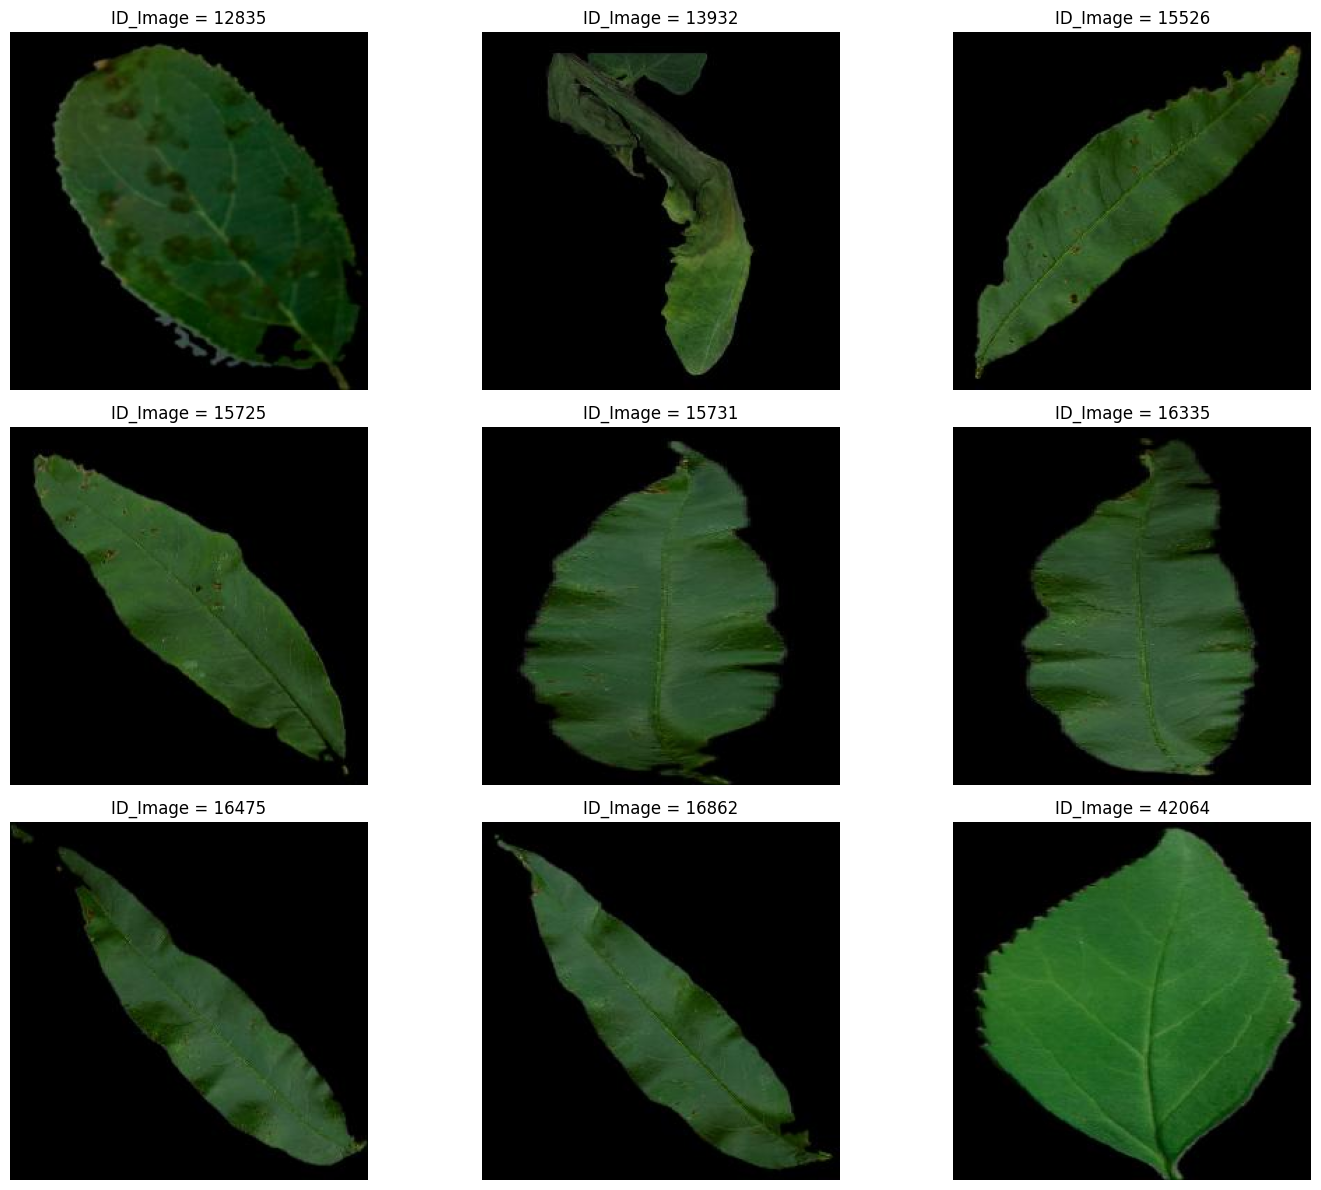

In [69]:
# 2. Filtrer le DataFrame
missing_df = reco_plant[reco_plant['ID_Image'].isin(missing_ids)]

# 3. Préparer la grille d'affichage (3 colonnes)
n = len(missing_df)
cols = 3
rows = (n + cols - 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 4*rows))

# 4. Parcourir et afficher
for ax, (_, row) in zip(axes.flatten(), missing_df.iterrows()):
    img_id = row['ID_Image']
    path   = row['Image_Path']
    # Charger l'image
    img = cv2.imread(path)
    if img is None:
        ax.text(0.5, 0.5, f"Fichier non trouvé\n{path}", 
                ha='center', va='center', color='red')
    else:
        # Convertir BGR → RGB pour matplotlib
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax.imshow(img)
    ax.set_title(f"ID_Image = {img_id}")
    ax.axis('off')

# 5. Masquer les subplots vides
for ax in axes.flatten()[n:]:
    ax.axis('off')

plt.tight_layout()
plt.show()

In [70]:
# Filtrage du DataFrame pour retirer ces lignes
df_clean = reco_plant[~reco_plant['ID_Image'].isin(missing_ids)].reset_index(drop=True)

# 3. (Optionnel) Vérifier qu’ils ont bien disparu
print("Ancien nombre de lignes :", len(reco_plant))
print("Nouveau nombre de lignes :", len(df_clean))


Ancien nombre de lignes : 54267
Nouveau nombre de lignes : 54258


In [72]:
df_clean.to_csv("Plant_V_Seg_all_features.csv", index=False)